In [1091]:
# This code is entirely my own work.

# imports
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, BatchNormalization
import matplotlib.pyplot as plt 
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from random import random, shuffle
from sklearn.metrics import accuracy_score
from python_speech_features import mfcc



### 1. Simple CNN classification

In [700]:
def tran(x, label1):
    if x == label1:
        return 1
    else:
        return 0

def get_cnn_classification(data_type, subject_num, label1, label2, num_epochs, test_size, verbose, plot, checks):
    '''We want to 
        i - import data from particular file of files (FEIS, KARAONE or ours)
        ii - get labels in from said files
        iii - separate X and y given the binary labels, 1s and 0s for y
        iv - create a CNN to perform 
    Give the function a filename / subject number / binary labels'''
    # check valid parameters given...
    try:
        assert type(data_type) == str
        assert type(subject_num) == int
        assert type(label1) == type(label2) == str

    except:
        print('Make sure the parameters are valid')

    # import the data given particular data type
    try:
        if data_type == 'custom':
            if checks:
                print('Importing raw eeg data...')
            raw_eeg = np.genfromtxt(f'imagined/labelled/imagined{subject_num}-labelled.csv', delimiter=',', dtype='float')[1:, 0:14]
            all_labels = np.genfromtxt(f'imagined/labelled/imagined{subject_num}-labelled.csv', delimiter=',', dtype='str')[1::256, -1]
            
            # separate out into X and y, dependant on labels, and split into training and testing data
            X, y = raw_eeg.reshape(1000, 256, 14, 1)[((all_labels == label1) + (all_labels == label2)), :, :], all_labels[((all_labels == label1) + (all_labels == label2))]
            if checks:
                print('Making binary numbers')
            y = np.array([tran(x, label1) for x in y])
            if checks:
                print('Train test split...')
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    except:
        print('Make sure your data_type and / or subject_num are valid inputs')

    if checks:
        print('Constructing CNN')
    # make the CNN given the above preprocessing
    model=Sequential()
    #adding convolutioy_train layer
    model.add(Conv2D(64,(3,3),activation='relu',input_shape=(256,14,1)))
    #adding pooling layer
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(Dense(64, activation='relu'))
    # model.add(Dense(512, activation='relu'))
    model.add(Flatten())
    #model.add(Dense(512,activation='relu'))
    #adding output layer
    model.add(Dense(1,activation='sigmoid'))
    #compiling the model
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    #fitting the model 
    history = model.fit(X_train, y_train, batch_size=10, epochs=num_epochs, validation_data=(X_test, y_test), verbose = verbose)
    if plot:
        plt.plot(np.arange(1, num_epochs + 1), history.history['val_accuracy'], label = 'Test accuracy')
        plt.plot(np.arange(1, num_epochs + 1), history.history['accuracy'], label = 'Training accuracy')
        plt.xlabel('No. of Epochs')
        plt.ylabel('Accuracy')
        plt.title('Subject {0}, {1} vs {2}'.format(subject_num, label1, label2))
        plt.legend()
        plt.show()
    return history

In [283]:
# declare variables
num_epochs = 7
data_type = 'custom'
label1 = 'date'
label2 = 'ambassador'
subject_num = 7
test_size = 0.2
verbose = False
plot = False
checks = False


test_labels = [('date', 'ambassador'), 
                ('goose', 'moose'), 
                ('night',  'knight'), 
                ('hedgehog', 'juice'),
                ('watermelon', 'waterfowl')]

for labels in test_labels:
    max_acc = []
    acc_max = []
    mean_acc = []
    label1, label2 = labels
    for i in range(100):
        if checks:
            print('Running trial {0} / {1}'.format(i + 1, 100))
        my_history = get_cnn_classification(data_type, subject_num, label1, label2, num_epochs, test_size, verbose, plot, checks)
        max_acc.append(max(my_history.history['val_accuracy']))
        mean_acc.append(np.mean(my_history.history['val_accuracy']))
        acc_max.append(np.argmax(my_history.history['val_accuracy']))
    print('Binary classification of {0} vs {1}'.format(label1, label2))
    print('===========================================')
    print('Mean of Mean test accuracies: {0}'.format(np.mean(mean_acc)))
    print('Std of Mean test accuracies: {0}'.format(np.std(mean_acc)))
    print('----------------------------------------------------')
    print('Mean of Max test accuracies: {0}'.format(np.mean(max_acc)))
    print('Std of Max test accuracies: {0}'.format(np.std(max_acc)))
    print()

Binary classification of date vs ambassador
Mean of Mean test accuracies: 0.5544285720586777
Std of Mean test accuracies: 0.06681362968088152
----------------------------------------------------
Mean of Max test accuracies: 0.671999996304512
Std of Max test accuracies: 0.07658981574922007

Binary classification of goose vs moose
Mean of Mean test accuracies: 0.5057857168146542
Std of Mean test accuracies: 0.06435468513875758
----------------------------------------------------
Mean of Max test accuracies: 0.6145000028610229
Std of Max test accuracies: 0.06453486653832322

Binary classification of night vs knight
Mean of Mean test accuracies: 0.5262142870894501
Std of Mean test accuracies: 0.05419216639452339
----------------------------------------------------
Mean of Max test accuracies: 0.6409999984502792
Std of Max test accuracies: 0.0736138508050758

Binary classification of hedgehog vs juice
Mean of Mean test accuracies: 0.5077142876599516
Std of Mean test accuracies: 0.0613677443

#### 1.x Feature extraction:
We will make a function which, given the subject_num and file type (imagined or inner), will return the array of features
for that subject

In [316]:
# get data in
mode_of_data = 'imagined'
raw_eeg, all_labels= np.genfromtxt(f'{mode_of_data}/labelled/{mode_of_data}{2}-labelled.csv', delimiter=',', dtype='float')[1:, 0:14], np.genfromtxt(f'{mode_of_data}/labelled/{mode_of_data}{2}-labelled.csv', delimiter=',', dtype='str')[1::256, -1]


In [701]:
# many of these functions came from FEIS depostory 
import antropy
import sys
from scipy import integrate, stats

def mean(x):
	return np.mean(x)

def absmean(x):
	return np.mean(np.abs(x))

def maximum(x):
	return np.max(x)

def absmax(x):
	return np.max(np.abs(x))

def minimum(x):
	return np.min(x)

def absmin(x):
	return np.min(np.abs(x)) 

def minplusmax(x):
	return np.max(x) + np.min(x)

def maxminusmin(x):
	return np.max(x) - np.min(x)

def curvelength(x):
	cl = 0
	for i in range(x.shape[0]-1):
		cl += abs(x[i]-x[i+1])
	return cl

def energy(x):
	return np.sum(np.multiply(x,x))

def nonlinear_energy(x):
	# NLE(x[n]) = x**2[n] - x[n+1]*x[n-1]
	x_squared = x[1:-1]**2
	subtrahend = x[2:]*x[:-2]
	return np.sum(x_squared-subtrahend)
	

def spec_entropy(x):
	return antropy.spectral_entropy(x, 128,method="welch",normalize=True)

def integral(x):
	return integrate.simps(x)

def stddeviation(x):
	return np.std(x)

def variance(x):
	return np.var(x)

def skew(x):
	return stats.skew(x)

def kurtosis(x):
	return stats.kurtosis(x)

def get_mfcc(x):
	return mfcc(x)


funclist = [mean,absmean,maximum,absmax,minimum,absmin,minplusmax,maxminusmin,curvelength,energy,nonlinear_energy, integral,stddeviation,variance,skew,np.sum,spec_entropy, kurtosis]


In [328]:
raw_eeg = raw_eeg.reshape(1000, 256, 14)
# window 1: 0 < T < 32
# window 2: 16 < T < 48
# ... 
# window 15: 240 < T < 256
labelled_data = []
feature_array = []
# data point 1: windows 1 -> 5 concat
# data point 2: windows 2 -> 6 concat
# ...
# data point 11: windows 11 -> 15 concat
funclist1 = [mean]
# loop through every event
for i in range(1000):
    epoch = raw_eeg[i]
    label = all_labels[i]
    windowed_data = []
    for j in range(15):
        window = np.array(epoch[(j * 16):((j + 2)*16)])
        outvec = np.zeros((len(funclist), window.shape[1]))
        for i, f in enumerate(funclist):
            # print('applying {}'.format(f.__name__))
            for col in range(window.shape[1]):
                outvec[i, col] = f(window[:, col])
        outvec = outvec.reshape(-1)
        windowed_data.append(outvec)
        
    # 1-> 5 ... 11 -> 15
    for k in range(11):
        feature_array.append(np.stack(windowed_data[(k):(k+5)]))
        labelled_data.append(label)

windowed_data = np.array(windowed_data)
feature_array = np.array(feature_array)

c:\Users\tonyc\anaconda3\envs\tensorflow\lib\site-packages\scipy\signal\_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 32, using nperseg = 32
  warnings.warn('nperseg = {0:d} is greater than input length '


### 2. SVM classification

In [1092]:
def binary_split(data, labels, label1, label2):
    '''One of the most important functions. Given some data array and corresponding labels, this function separates out
    the data corresponding to the two labels passed to the function'''
    new_features, new_labels = data[(np.array(labels) == label1) + (np.array(labels) == label2)].astype('float32'), np.array(labels)[(np.array(labels) == label1) + (np.array(labels) == label2)]
    new_labels1 = [tran(x, label1) for x in new_labels]
    return new_features, new_labels1

In [315]:
from sklearn import svm

feats, labs = binary_split('goose', 'moose')
#X = [[0, 0], [1, 1]]
#y = [0, 1]
feats = feats.reshape(feats.shape[0], feats.shape[1] * feats.shape[2])


for C in [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]:
    test_accs= []
    for round in range(100):
        clf = svm.SVC(C=C)
        feats_train, feats_test, labs_train, labs_test = train_test_split(feats, labs, shuffle=True, random_state=round)
        clf.fit(feats_train, labs_train)
        preds = clf.predict(feats_test)
        test_accs.append(accuracy_score(labs_test, preds))
    print('C = {0}, avg. test accuracy = {1}'.format(C, np.mean(test_accs)))
    print('sd: {}'.format(np.std(test_accs)))

C = 0.01, avg. test accuracy = 0.47839999999999994
sd: 0.015861549745550672
C = 0.1, avg. test accuracy = 0.4895636363636363
sd: 0.02842722475793261
C = 1.0, avg. test accuracy = 0.5517454545454545
sd: 0.03263767533449142
C = 10.0, avg. test accuracy = 0.6190545454545454
sd: 0.03360487961419141
C = 100.0, avg. test accuracy = 0.7065090909090909
sd: 0.02512143071148089
C = 1000.0, avg. test accuracy = 0.7431272727272726
sd: 0.023451134353786356
C = 10000.0, avg. test accuracy = 0.7428363636363637
sd: 0.024469674265868064


### 3. kNN classification

In [337]:
feats.shape

(1100, 1190)

In [354]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

parameters = {"n_neighbors": range(1, 100)}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(feats_train, labs_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 100)})

In [353]:
feats_train, feats_test, labs_train, labs_test = train_test_split(feats, labs, shuffle=True, random_state=round)

In [360]:
preds = np.array([np.round(i) for i in gridsearch.predict(feats_test)])

accuracy_score(labs_test, preds)

0.8254545454545454

### 4. Random Forest classification

{'n_estimators': 162}

In [383]:
from sklearn.preprocessing import StandardScaler

feats_train, feats_test = StandardScaler().fit_transform(feats_train), StandardScaler().fit_transform(feats_test)

In [388]:
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(.95)

pca.fit(feats_train)

PCA(n_components=0.95)

In [391]:
feats_train = pca.transform(feats_train)
feats_test = pca.transform(feats_test)

In [392]:
feats_train.shape

(825, 178)

In [400]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
parameters = {'n_estimators' : range(1, 200)}
gridsearch_rf = GridSearchCV(RandomForestRegressor(), parameters)
# rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
gridsearch_rf.fit(feats_train, labs_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'n_estimators': range(1, 200)})

In [402]:
preds = np.array([np.round(j) for j in gridsearch_rf.predict(feats_test)])

In [403]:
accuracy_score(labs_test, preds)

0.7127272727272728

In [401]:
gridsearch_rf.best_params_

{'n_estimators': 162}

# Automation for testing, cross validating, Outputting results

In [1404]:
# kfold splitting object
kfold = sklearn.model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state=1)

def get_data(type_of_data = 'imagined', subject_num = 1):
    '''Gets the data from the directory given the type of data
    and which subject to get it from. Returns an array (raw_eeg, labels)'''
    raw_eeg, all_labels = np.genfromtxt(f'{type_of_data}/labelled/{type_of_data}{subject_num}-labelled.csv', delimiter=',', dtype='float')[1:, 0:14], np.genfromtxt(f'{type_of_data}/labelled/{type_of_data}{subject_num}-labelled.csv', delimiter=',', dtype='str')[1::256, -1]
    return raw_eeg, all_labels


def get_windows(raw_eeg, all_labels, raw = False):
    '''Gets the windows for our eeg data, 15 windows per epoch, length 32 windows. EEG data must be split binary.
    Returns the windowed data, the labels for each window and the feature array, and the labels for each feature array'''
    if raw == True:
        raw_eeg = raw_eeg.reshape(len(all_labels), 256, 14)
        labelled_data = []
        feature_array = []
        all_windows = []
        window_labels = []
        for i in range(raw_eeg.shape[0]):
            epoch = raw_eeg[i]
            label = all_labels[i]
            for j in range(15):
                window = np.array(epoch[(j * 16):((j + 2)*16)])
                all_windows.append(window)
                window_labels.append(label)

        return np.array(all_windows), window_labels

    else:
        raw_eeg = raw_eeg.reshape(len(all_labels), 256, 14)
        labelled_data = []
        feature_array = []
        for i in range(raw_eeg.shape[0]):
            epoch = raw_eeg[i]
            label = all_labels[i]
            windowed_data = []
            for j in range(15):
                window = np.array(epoch[(j * 16):((j + 2)*16)])
                outvec = np.zeros((len(funclist), window.shape[1]))
                for i, f in enumerate(funclist):
                    # print('applying {}'.format(f.__name__))
                    for col in range(window.shape[1]):
                        outvec[i, col] = f(window[:, col])
                outvec = outvec.reshape(-1)
                windowed_data.append(outvec)

            # 1-> 5 ... 11 -> 15
            for k in range(11):
                feature_array.append(np.stack(windowed_data[(k):(k+5)]))
                labelled_data.append(label)

        feature_array = np.array(feature_array)
        return feature_array, np.array(labelled_data)


def build_model(input_shape):
    model=Sequential()
    #adding convolutioy_train layer
    model.add(Conv2D(32, (3,3), activation='relu',input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.1))
   #  model.add(Flatten())
    # model.add(Dense(128,activation='relu'))
    # model.add(Dense(256,activation='relu'))

    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model


# CNN-Raw
def test_cnn_raw(type_of_data, subject_num, label1, label2):
    print('Subject {}, {}'.format(subject_num, type_of_data))
    # import data
    raw_eeg, all_labels = get_data(type_of_data, subject_num)

    raw_eeg = raw_eeg.reshape(1000, 256, 14, 1)

    # split into train and test

    # # window train and test data, computing feature on windows and grouping together as neccessary
    # windows, window_labels, features, feature_labels = get_windows(raw_eeg, labels)

    # # get binary raw_eeg and labels for train and test data
    # windows, window_labels = binary_split(windows, window_labels, label1, label2)
    # windows = windows.reshape(windows.shape[0], windows.shape[1], windows.shape[2], 1)
    
    # # initiate k = 5 cross validation using same splits each time
    # input_shape = (windows.shape[1], windows.shape[2], 1)
    # window_labels = np.array(window_labels)
    val_accuracies = []

    for train_ind, val_ind in list(kfold.split(raw_eeg, all_labels)):
        # build model
        train_windows, train_labels = binary_split(raw_eeg[train_ind], all_labels[train_ind], label1, label2)
        test_windows, test_labels = binary_split(raw_eeg[val_ind], all_labels[val_ind], label1, label2)

        tr_windows, tr_window_labels = get_windows(train_windows, train_labels, True)
        te_windows, te_window_labels= get_windows(test_windows, test_labels, True)
        tr_window_labels, te_window_labels = np.array(tr_window_labels), np.array(te_window_labels)


        input_shape = (tr_windows.shape[1], tr_windows.shape[2], 1)
        tr_windows, te_windows = tr_windows.reshape(tr_windows.shape[0], input_shape[0], input_shape[1], input_shape[2]), te_windows.reshape(te_windows.shape[0], input_shape[0], input_shape[1], input_shape[2])
        model = build_model(input_shape = input_shape)

        history = model.fit(tr_windows, tr_window_labels, epochs=10, validation_data = (te_windows, te_window_labels), verbose = False)
        val_accuracies.append(history.history['val_accuracy'])

    print('Binary classification between {} and {} for subject {}, {}'.format(label1, label2, subject_num, type_of_data))
    print('================================================================================================')
    print('10 fold Cross-validated accuracy: {} +- {}'.format(np.mean(val_accuracies), np.std(val_accuracies)))

    return np.mean(val_accuracies), np.std(val_accuracies)


In [1097]:
import warnings
warnings.filterwarnings("ignore")

In [1416]:
# pairs to check
label_pairs = [('goose', 'moose'), ('moose', 'spruce'),
                ('moose', 'caterpillar'), ('juice', 'waterfowl'),
                ('hedgehog', 'goose'), ('night', 'knight'), ('date', 'juice'), 
                ('hedgehog', 'waterfowl'), ('juice', 'ambassador')]

cnn_raw_accs_2 = np.zeros(shape = (8, 2, 9))
cnn_raw_std_2 = np.zeros(shape = (8, 2, 9))

for subject_num in range(1, 9):
    for d, data_type in enumerate(['imagined', 'inner']):
        for l, (label1, label2) in enumerate(label_pairs):
            m, s = test_cnn_raw(data_type, subject_num, label1, label2)
            cnn_raw_accs_2[subject_num - 1][d][l] += m
            cnn_raw_std_2[subject_num - 1][d][l] += s

Subject 1, imagined
Binary classification between goose and moose for subject 1, imagined
10 fold Cross-validated accuracy: 0.5596666711568833 +- 0.03892015021190242
Subject 1, imagined
Binary classification between moose and spruce for subject 1, imagined
10 fold Cross-validated accuracy: 0.5367999976873398 +- 0.02737362797261045
Subject 1, imagined
Binary classification between moose and caterpillar for subject 1, imagined
10 fold Cross-validated accuracy: 0.5543999981880188 +- 0.0449811844716861
Subject 1, imagined
Binary classification between juice and waterfowl for subject 1, imagined
10 fold Cross-validated accuracy: 0.5217333352565765 +- 0.048708839212146963
Subject 1, imagined
Binary classification between hedgehog and goose for subject 1, imagined
10 fold Cross-validated accuracy: 0.5044666659832001 +- 0.035059378824560714
Subject 1, imagined
Binary classification between night and knight for subject 1, imagined
10 fold Cross-validated accuracy: 0.5223333334922791 +- 0.043010

In [1431]:
# CNN-Feats
def build_feat_model(input_shape):
    model=Sequential()
    #adding convolutioy_train layer
    # model.add(Conv2D(32, (3,3), activation='relu',input_shape=input_shape))
    # model.add(Conv2D(64, (3,3), activation='relu'))
    # model.add(MaxPool2D((1,1)))
    # model.add(Dropout(0.1))
    # model.add(Flatten())
    # model.add(Dense(128,activation='relu'))
    # model.add(Dense(256,activation='relu'))
    model.add(Conv2D(32, (3,3), activation='relu',input_shape=input_shape))
    model.add(MaxPool2D((1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPool2D((1,1)))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.1))
   #  model.add(Flatten())
    # model.add(Dense(128,activation='relu'))
    # model.add(Dense(256,activation='relu'))

    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model

def test_cnn_feats(data, labels, type_of_data, subject_num, label1, label2):
    '''Build a CNN that runs on the features generated by the windows of the raw eeg... Works similarly to last
    function but different input_shape for the model. '''

    print('Subject {}, {}'.format(subject_num, type_of_data))
    # import data
    # raw_eeg, all_labels = get_data(type_of_data, subject_num)

    raw_eeg = data.reshape(1000, 256, 14, 1)

    val_accuracies = []
    for train_ind, val_ind in list(kfold.split(raw_eeg, labels)):
        train_windows, train_labels = binary_split(raw_eeg[train_ind], all_labels[train_ind], label1, label2)
        test_windows, test_labels = binary_split(raw_eeg[val_ind], all_labels[val_ind], label1, label2)

        tr_features, tr_features_labels = get_windows(train_windows, train_labels, False)
        te_features, te_features_labels= get_windows(test_windows, test_labels, False)
        trshap1, teshape2 = (tr_features.shape[1], tr_features.shape[2]), (te_features.shape[1], te_features.shape[2])
        tr_features, te_features = tr_features.reshape((tr_features.shape[0], tr_features.shape[1] * tr_features.shape[2])), te_features.reshape((te_features.shape[0], te_features.shape[1] * te_features.shape[2]))

        tr_features = StandardScaler().fit_transform(tr_features)
        te_features = StandardScaler().fit_transform(te_features)

        tr_features, te_features = tr_features.reshape((tr_features.shape[0], trshap1[0], trshap1[1])), te_features.reshape((te_features.shape[0], teshape2[0], teshape2[1]))

        tr_features_labels, te_features_labels = np.array(tr_features_labels), np.array(te_features_labels)

        
        input_shape = (tr_features.shape[1], tr_features.shape[2], 1)
        tr_features, te_features = tr_features.reshape(tr_features.shape[0], input_shape[0], input_shape[1], input_shape[2]), te_features.reshape(te_features.shape[0], input_shape[0], input_shape[1], input_shape[2])
        model = build_feat_model(input_shape = input_shape)
    
        history = model.fit(tr_features, tr_features_labels, epochs=10, validation_data = (te_features, te_features_labels), verbose = False)
        val_accuracies.append(history.history['val_accuracy'])
        

    print('CNN features Binary classification between {} and {} for subject {}, {}'.format(label1, label2, subject_num, type_of_data))
    print('================================================================================================')
    print('10 fold Cross-validated accuracy: {} +- {}'.format(np.mean(val_accuracies), np.std(val_accuracies)))
    print()
    return np.mean(val_accuracies), np.std(val_accuracies)


cnn_feat_accs = np.zeros(shape = (8, 2, 9))
cnn_feat_std = np.zeros(shape = (8, 2, 9))

        
for subject_num in range(1, 9):
    for d, data_type in enumerate(['imagined', 'inner']):
        raw_eeg, all_labels = get_data(data_type, subject_num)
        for l, (label1, label2) in enumerate(label_pairs):
            m, s = test_cnn_feats(raw_eeg, all_labels, data_type, subject_num, label1, label2)
            cnn_feat_accs[subject_num - 1][d][l] += m
            cnn_feat_std[subject_num - 1][d][l] += s

Subject 8, imagined
CNN features Binary classification between goose and moose for subject 8, imagined
10 fold Cross-validated accuracy: 0.6204545450210571 +- 0.07857327596400375

Subject 8, imagined
CNN features Binary classification between moose and spruce for subject 8, imagined
10 fold Cross-validated accuracy: 0.5293636333942413 +- 0.058797943422049796

Subject 8, imagined
CNN features Binary classification between moose and caterpillar for subject 8, imagined
10 fold Cross-validated accuracy: 0.4949999976158142 +- 0.0682681261700908

Subject 8, imagined
CNN features Binary classification between juice and waterfowl for subject 8, imagined
10 fold Cross-validated accuracy: 0.5279090917110443 +- 0.053000938185908175

Subject 8, imagined
CNN features Binary classification between hedgehog and goose for subject 8, imagined
10 fold Cross-validated accuracy: 0.6185454523563385 +- 0.04777564668961955

Subject 8, imagined
CNN features Binary classification between night and knight for s

In [1133]:
# kfold split for CV
kfold = sklearn.model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)

# pca object for explaining the variance in the training data. 
pca = PCA(0.95)

cv = sklearn.model_selection.KFold(n_splits=5, random_state=1, shuffle=True)
# SVM-rbf
C_s = [1e0, 1e1, 1e2, 1e3, 1e4]


def test_svm(data, labels, subject_num, data_type, label1, label2):
    '''Builds an SVM using an rbf kernel to classify the raw windowed, featured data
    given the subject num, and labels to perform binary classification between. PCA is also performed per subject. And a 10 
    fold CV'''
    print('Subject {}, {}'.format(subject_num, data_type))
    #labels = np.array(labels)
    data = data.reshape(1000, 256, 14, 1)

    # window data, and get features
    
    # # do a binary split based on labels
    # features, feature_labels = binary_split(features, feature_labels, label1, label2)
    # feature_labels = np.array(feature_labels)

    # features = features.reshape(features.shape[0], features.shape[1] * features.shape[2])
    val_accuracies = []
    for train_ind, val_ind in list(kfold.split(data, labels)):

        tr_features, tr_feature_labels = binary_split(data[train_ind], labels[train_ind], label1, label2)
        te_features, te_feature_labels = binary_split(data[val_ind], labels[val_ind], label1, label2)

        tr_features, tr_feature_labels = get_windows(tr_features, tr_feature_labels, False)

        te_features, te_feature_labels = get_windows(te_features, te_feature_labels, False)


        # reshape
        tr_features = tr_features.reshape(tr_features.shape[0], tr_features.shape[1] * tr_features.shape[2])
        te_features = te_features.reshape(te_features.shape[0], te_features.shape[1] * te_features.shape[2])
        #standardize now...
        feats_train, feats_val = StandardScaler().fit_transform(tr_features), StandardScaler().fit_transform(te_features)
        feats_train = np.nan_to_num(feats_train)
        feats_val = np.nan_to_num(feats_val)
        # # perform pca on training features
        feats_train = pca.fit_transform(feats_train)
        feats_val = pca.transform(feats_val)

        cv_scores = []
        svm_clf = svm.SVC(C = 1000)
        svm_clf.fit(feats_train, tr_feature_labels)
        val_accuracies.append(accuracy_score(te_feature_labels, svm_clf.predict(feats_val)))

    print('SVM-rbf Binary classification between {} and {} for subject {}, {}'.format(label1, label2, subject_num, data_type))
    print('================================================================================================')
    print('10 fold Cross-validated accuracy: {} +- {}'.format(np.mean(val_accuracies), np.std(val_accuracies)))
    print()
    return np.mean(val_accuracies), np.std(val_accuracies)

svm_feat_accs = np.zeros(shape = (8, 2, 9))
svm_feat_std = np.zeros(shape = (8, 2, 9))

for subject_num in range(1, 9):
    for d, data_type in enumerate(['imagined', 'inner']):
        data, labels = get_data(data_type, subject_num)
        for l, (label1, label2 )in enumerate(label_pairs):
            m, s = test_svm(data, labels, subject_num, data_type, label1, label2)
            svm_feat_accs[subject_num - 1][d][l] += m
            svm_feat_std[subject_num - 1][d][l] += s


Subject 1, imagined
SVM-rbf Binary classification between goose and moose for subject 1, imagined
10 fold Cross-validated accuracy: 0.6545454545454545 +- 0.03602111410210719

Subject 1, imagined
SVM-rbf Binary classification between moose and spruce for subject 1, imagined
10 fold Cross-validated accuracy: 0.5727272727272728 +- 0.05742404253583184

Subject 1, imagined
SVM-rbf Binary classification between moose and caterpillar for subject 1, imagined
10 fold Cross-validated accuracy: 0.5645454545454546 +- 0.06576944453703971

Subject 1, imagined
SVM-rbf Binary classification between juice and waterfowl for subject 1, imagined
10 fold Cross-validated accuracy: 0.5272727272727272 +- 0.08581163303210332

Subject 1, imagined
SVM-rbf Binary classification between hedgehog and goose for subject 1, imagined
10 fold Cross-validated accuracy: 0.5890909090909091 +- 0.07080411810407547

Subject 1, imagined
SVM-rbf Binary classification between night and knight for subject 1, imagined
10 fold Cros

In [1167]:
# kNN
parameters = {"n_neighbors": range(1, 100)}

def test_knn(data, labels, label1, label2):
    '''Takes in the features from a particular subject, and data_type and performs knn on the data. 
    Given the labels too. It will:
        1. split the data based on the labels
        2. standardize the features
        3. perform pca on the training set and transform both training and testing
        4. Cross validate using training set to get best k'''
    data = data.reshape(1000, 256, 14)
   
    feats, labs = binary_split(data, labels, label1, label2)
    labs = np.array(labs)

    feats = feats.reshape(feats.shape[0], feats.shape[1] * feats.shape[2])
    val_accuracies = []
    best_k = []
    for train_ind, val_ind in list(kfold.split(feats, labs)):
        feats_train, ft_labels = get_windows(feats[train_ind], labs[train_ind])
        feats_val, fv_labels = get_windows(feats[val_ind], labs[val_ind])

        feats_train = feats_train.reshape(feats_train.shape[0], feats_train.shape[1] * feats_train.shape[2])
        feats_val = feats_val.reshape(feats_val.shape[0], feats_val.shape[1] * feats_val.shape[2])
        #standardize now...
        feats_train = np.nan_to_num(feats_train)
        feats_val = np.nan_to_num(feats_val)
        feats_train, feats_val = StandardScaler().fit_transform(feats_train), StandardScaler().fit_transform(feats_val)
        # perform pca on training features
        pca.fit(feats_train)
        feats_train, feats_val = pca.transform(feats_train), pca.transform(feats_val)

        # cross validation for best k, task dependent
        gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
        gridsearch.fit(feats_train, ft_labels)
        best_k.append(gridsearch.best_params_['n_neighbors'])
        #predict our test set and record a score
        preds = [np.round(i) for i in gridsearch.predict(feats_val)]
        val_accuracies.append(accuracy_score(fv_labels, preds))

    print('KNN Binary classification between {} and {} for subject {}, {}'.format(label1, label2, subject_num, data_type))
    print('================================================================================================')
    print('Best k on average = {}'.format(np.mean(best_k)))
    print('-------------------------------------------------------------------------------------------------')
    print('10 fold Cross-validated accuracy: {} +- {}'.format(np.mean(val_accuracies), np.std(val_accuracies)))
    print()
    return np.mean(val_accuracies), np.std(val_accuracies)

knn_feat_acc = np.zeros((8, 2, 9))
knn_feat_std = np.zeros((8, 9, 2))

for subject_num in range(1, 9):
    for i, data_type in enumerate(['imagined', 'inner']):
        print('Subject {}, {}'.format(subject_num, data_type))
        data, labels = get_data(data_type, subject_num)
        for l, (label1, label2) in enumerate(label_pairs):
            m, s = test_knn(data, labels, label1, label2)
            knn_feat_acc[subject_num - 1][i][l] += m
            knn_feat_std[subject_num - 1][i][l] += s

Subject 8, imagined
KNN Binary classification between goose and moose for subject 8, imagined
Best k on average = 72.0
-------------------------------------------------------------------------------------------------
10 fold Cross-validated accuracy: 0.6309090909090909 +- 0.09033454808937941

KNN Binary classification between moose and spruce for subject 8, imagined
Best k on average = 98.4
-------------------------------------------------------------------------------------------------
10 fold Cross-validated accuracy: 0.5218181818181818 +- 0.10314877324276621

KNN Binary classification between moose and caterpillar for subject 8, imagined
Best k on average = 98.2
-------------------------------------------------------------------------------------------------
10 fold Cross-validated accuracy: 0.4981818181818182 +- 0.029681504940571833

KNN Binary classification between juice and waterfowl for subject 8, imagined
Best k on average = 91.6
-----------------------------------------------

In [1170]:
# rf 

def test_rf(data, labels, label1, label2):
    '''Takes in the features from a particular subject, and data_type and performs knn on the data. 
    Given the labels too. It will:
        1. split the data based on the labels
        2. standardize the features
        3. perform pca on the training set and transform both training and testing
        4. Just train with initial parameters as cross validating for best n_features will take too long, 100 trees
        per forest'''

    data = data.reshape(1000, 256, 14)
    feats, labs = binary_split(data, labels, label1, label2)
    labs = np.array(labs)

    feats = feats.reshape(feats.shape[0], feats.shape[1] * feats.shape[2])
    val_accuracies = []
    for train_ind, val_ind in list(kfold.split(feats, labs)):
        feats_train, feats_train_labels = get_windows(feats[train_ind], labs[train_ind], False)
        feats_val, feats_val_labels = get_windows(feats[val_ind], labs[val_ind], False)
        feats_train, feats_val = feats_train.reshape(feats_train.shape[0], feats_train.shape[1] * feats_train.shape[2]), feats_val.reshape(feats_val.shape[0], feats_val.shape[1] * feats_val.shape[2])
        #standardize now...
        feats_train, feats_val = StandardScaler().fit_transform(feats_train), StandardScaler().fit_transform(feats_val)
        # perform pca on training features
        feats_train, feats_val = np.nan_to_num(feats_train), np.nan_to_num(feats_val)

        pca.fit(feats_train)
        feats_train, feats_val = pca.transform(feats_train), pca.transform(feats_val)

        # cross validation for best k, task dependent
        rf_clf = RandomForestRegressor()
        rf_clf.fit(feats_train, feats_train_labels)

        #predict our test set and record a score
        preds = [np.round(i) for i in rf_clf.predict(feats_val)]
        val_accuracies.append(accuracy_score(feats_val_labels, preds))

    print('RF Binary classification between {} and {} for subject {}, {}'.format(label1, label2, subject_num, data_type))
    print('================================================================================================')
    print('10 fold Cross-validated accuracy: {} +- {}'.format(np.mean(val_accuracies), np.std(val_accuracies)))
    print()
    return np.mean(val_accuracies), np.std(val_accuracies)



# for subject_num in range(1, 9):
#     for data_type in ['imagined', 'inner']:
#         print('Subject {}, {}'.format(subject_num, data_type))
#         data, labels = get_data(data_type, subject_num)
#         for label1, label2 in label_pairs:
#             test_rf(data, labels, label1, label2 )
rf_feat_acc = np.zeros((8, 2, 9))
rf_feat_std = np.zeros((8, 2, 9))

for subject_num in range(1, 9):
    for i, data_type in enumerate(['imagined', 'inner']):
        print('Subject {}, {}'.format(subject_num, data_type))
        data, labels = get_data(data_type, subject_num)
        for l, (label1, label2) in enumerate(label_pairs):
            m, s = test_rf(data, labels, label1, label2 )
            rf_feat_acc[subject_num - 1][i][l] += m
            rf_feat_std[subject_num - 1][i][l] += s

Subject 1, imagined
RF Binary classification between goose and moose for subject 1, imagined
10 fold Cross-validated accuracy: 0.6109090909090908 +- 0.0770638889182645

RF Binary classification between moose and spruce for subject 1, imagined
10 fold Cross-validated accuracy: 0.5054545454545455 +- 0.012662171161076478

RF Binary classification between moose and caterpillar for subject 1, imagined
10 fold Cross-validated accuracy: 0.5254545454545454 +- 0.06609534810652197

RF Binary classification between juice and waterfowl for subject 1, imagined
10 fold Cross-validated accuracy: 0.5336363636363637 +- 0.06540402090401799

RF Binary classification between hedgehog and goose for subject 1, imagined
10 fold Cross-validated accuracy: 0.5736363636363636 +- 0.02496278221408361

RF Binary classification between night and knight for subject 1, imagined
10 fold Cross-validated accuracy: 0.5054545454545455 +- 0.05816761190198687

RF Binary classification between date and juice for subject 1, im

In [1327]:
# add the MFCC (Mel Frequency Cepstral Coefficients) features
def get_mfcc_feature_set(data, subject_num, data_type, all_labels):
    '''Test the svm using the MFCCs of the windows as our feature set. Will print some stuff and we can compare to the other features.'''
    raw_eeg = data.reshape(len(all_labels), 256, 14)
    labelled_data = []
    feature_array = []
    all_windows = []
    window_labels = []
    for i in range(len(all_labels)):
        epoch = raw_eeg[i]
        label = all_labels[i]
        windowed_data = []
        for j in range(15):
            window = np.array(epoch[(j * 16):((j + 2)*16)])
            all_windows.append(window)
            window_labels.append(label)
            outvec = np.zeros((13, window.shape[1]))
            for col in range(window.shape[1]):
                outvec[:, col] = mfcc((window[:, col]))
            outvec = outvec.reshape(-1)
            windowed_data.append(outvec)
            
        # 1-> 5 ... 11 -> 15
        for k in range(11):
            feature_array.append(np.stack(windowed_data[(k):(k+5)]))
            labelled_data.append(label)

    windowed_data = np.array(windowed_data)
    feature_array = np.array(feature_array)
    return np.array(all_windows), window_labels, feature_array, labelled_data
# Spectral correnstropy matrix

# distance metrics in KNNs

# try to download KARAONE data set and perform transfer learning, on CNN only 

# get average matrix of each data point, and calculate 'distance' between them
# - L2, L1 distances
# - Covariance matrix
# - MFCC
# - Riemannian distance


In [1403]:
def test_svm_mfcc(data, labels, subject_num, data_type, label1, label2):
    '''Builds an SVM using an rbf kernel to classify the raw windowed, featured data
    given the subject num, and labels to perform binary classification between. PCA is also performed per subject. And a 10 
    fold CV'''
    print('Subject {}, {}'.format(subject_num, data_type))

    # window data, and get features
    new_data = data.reshape(1000, 256, 14)
    # do a binary split based on labels
    new_data, labels = binary_split(new_data, labels, label1, label2)
    labels = np.array(labels)

    #new_data = new_data.reshape(new_data.shape[0], new_data.shape[1] ,new_data.shape[2])
    val_accuracies = []
    for train_ind, val_ind in list(kfold.split(new_data, labels)):
        windows_tr, window_labels_tr, feats_train, feats_train_labels = get_mfcc_feature_set(new_data[train_ind], subject_num, data_type, labels[train_ind])
        windows_te, window_labels_tr, feats_val, feats_val_labels = get_mfcc_feature_set(new_data[val_ind], subject_num, data_type, labels[val_ind])
        #standardize now...
        feats_train, feats_val = feats_train.reshape(feats_train.shape[0], feats_train.shape[1] * feats_train.shape[2]), feats_val.reshape(feats_val.shape[0], feats_val.shape[1] * feats_val.shape[2])

        feats_train, feats_val = StandardScaler().fit_transform(feats_train), StandardScaler().fit_transform(feats_val)
        # perform pca on training features
        feats_train, feats_val = np.nan_to_num(feats_train), np.nan_to_num(feats_val)
        pca.fit(feats_train)
        feats_train, feats_val = pca.transform(feats_train), pca.transform(feats_val)
        svm_clf = svm.SVC(C = 1000)
        svm_clf.fit(feats_train, feats_train_labels)
        val_accuracies.append(accuracy_score(feats_val_labels, svm_clf.predict(feats_val)))

    print('SVM-rbf MFCCs Binary classification between {} and {} for subject {}, {}'.format(label1, label2, subject_num, data_type))
    print('================================================================================================')
    print('10 fold Cross-validated accuracy: {} +- {}'.format(np.mean(val_accuracies), np.std(val_accuracies)))
    print()
    return np.mean(val_accuracies), np.std(val_accuracies)

svm_mfcc_acc = np.zeros((8, 2, 9))
svm_mfcc_std = np.zeros((8, 2, 9))

for subject_num in range(1, 9):
    for d, data_type in enumerate(['imagined', 'inner']):
        data, labels = get_data(data_type, subject_num)
        for l, (label1, label2) in enumerate(label_pairs):
            m,s = test_svm_mfcc(data, labels, subject_num, data_type, label1, label2)
            svm_mfcc_acc[subject_num - 1][d][l] += m
            svm_mfcc_std[subject_num - 1][d][l] += s

Subject 1, imagined
SVM-rbf MFCCs Binary classification between goose and moose for subject 1, imagined
10 fold Cross-validated accuracy: 0.6163636363636364 +- 0.06909090909090912

Subject 1, imagined
SVM-rbf MFCCs Binary classification between moose and spruce for subject 1, imagined
10 fold Cross-validated accuracy: 0.5390909090909091 +- 0.07743832523289763

Subject 1, imagined
SVM-rbf MFCCs Binary classification between moose and caterpillar for subject 1, imagined
10 fold Cross-validated accuracy: 0.5545454545454545 +- 0.0703004179242953

Subject 1, imagined
SVM-rbf MFCCs Binary classification between juice and waterfowl for subject 1, imagined
10 fold Cross-validated accuracy: 0.5345454545454545 +- 0.08574418998219344

Subject 1, imagined
SVM-rbf MFCCs Binary classification between hedgehog and goose for subject 1, imagined
10 fold Cross-validated accuracy: 0.5409090909090909 +- 0.032903565583370674

Subject 1, imagined
SVM-rbf MFCCs Binary classification between night and knight 

In [1208]:
import os

In [1445]:
import csv 
accs = [cnn_raw_accs_2, cnn_feat_accs, svm_feat_accs, svm_mfcc_acc, knn_feat_acc, rf_feat_acc]
stds = [cnn_raw_std_2, cnn_feat_std, svm_feat_std, svm_mfcc_std, knn_feat_std, rf_feat_std]


In [1446]:
folder_names = ['cnn_raw', 'cnn_feat', 'svm_feat', 'svm_mfcc', 'knn_feat', 'rf_feat']

for i, model in enumerate(accs):
    for subject_num in range(8):
        for k, type in enumerate(['imagined', 'inner']):
            df = pd.DataFrame((accs[i][subject_num][k], stds[i][subject_num][k]), columns=label_pairs).T
            folder_name = f'results/{folder_names[i]}/subject{subject_num+1}'
            file_name = f'{type}.csv'
            if not os.path.exists(folder_name):
                os.makedirs(folder_name)
            df.to_csv(folder_name+'/'+file_name)

In [1260]:
data, labels = get_data('imagined', 1)

In [1449]:
cnn_raw_accs_2.shape

(8, 2, 9)

In [1450]:
cnn_raw_accs_2

array([[[0.55966667, 0.5368    , 0.5544    , 0.52173334, 0.50446667,
         0.52233333, 0.48433333, 0.5032    , 0.57086666],
        [0.56326667, 0.51213333, 0.57313334, 0.53866667, 0.50353334,
         0.5298    , 0.48039999, 0.50706666, 0.55353333]],

       [[0.55246666, 0.56286667, 0.53933334, 0.514     , 0.49966667,
         0.53686667, 0.50246666, 0.5268    , 0.53493333],
        [0.52926666, 0.49586667, 0.5202    , 0.51986667, 0.51946666,
         0.507     , 0.46286666, 0.5404    , 0.501     ]],

       [[0.56226667, 0.47233333, 0.4698    , 0.57433333, 0.53406667,
         0.59746667, 0.5142    , 0.50566666, 0.49786666],
        [0.52866667, 0.51833333, 0.53593333, 0.52386667, 0.52566667,
         0.59346667, 0.4672    , 0.53393334, 0.4944    ]],

       [[0.56233334, 0.5242    , 0.55293333, 0.4798    , 0.52006667,
         0.46286667, 0.4934    , 0.50586666, 0.50286666],
        [0.54206667, 0.50793333, 0.50713333, 0.522     , 0.51713333,
         0.54553334, 0.56046667, 0.5

In [1878]:
import seaborn as sns
from Levenshtein import distance as lev
import gensim
pretrained_embeddings_path = "C:/Users/tonyc/Documents/Python Scripts/DISSERTATION/Scripts/GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(pretrained_embeddings_path, binary=True)

In [1576]:
from scipy.stats import spearmanr

In [1557]:
lev_distances = {}
cos_similarity = {}
lev_dists = []
cos_sims = []

word_list = ['date', 'goose', 'spruce', 'knight', 'juice', 
            'moose', 'night', 'queen', 'berry', 'hedgehog', 
            'water', 'daughter', 'gooseberry', 'waterfowl', 
            'wilderness', 'relative', 'watermelon', 'caterpillar', 
            'environment', 'ambassador']
for i in word_list:
    for j in word_list:
        if i != j:
            lev_distances[i + ' ' + j] = lev(i, j)
            cos_similarity[i + ' ' + j] = word2vec.similarity(i, j)

for label1, label2 in label_pairs:
    # print(f'{label1} and {label2}')
    # print('Cosine similarity: {}'.format(cos_similarity[label1 + ' '+label2]))
    # print('Levehnstein distance: {}'.format(lev_distances[label1 + ' '+label2]))
    # print('Syllable ditance: {}'.format(syllable_dist[label1 + ' '+label2]))
    # print()
    lev_dists.append(lev_distances[label1 + ' '+label2])
    cos_sims.append(cos_similarity[label1 + ' '+label2])
    # print('{}&{}&{}&{}&{:.4f} \\\\'.format(label1, label2, str.upper(label1[0] + label2[0]),lev_distances[label1 + ' '+label2], cos_similarity[label1 + ' '+label2]))

# RAW CNN PLOTS

In [1480]:
df_cnnraw = pd.DataFrame(columns=['data_type', 'subject', 'accuracy'])
data_types = ['imagined', 'inner']

for num, subject in enumerate(cnn_raw_accs_2):
    for d, accs in enumerate(subject):
        for acc in accs:
            df_cnnraw.loc[len(df_cnnraw.index)] = [data_types[d], f'subject {num+1}', acc]

df_cnnraw.accuracy = df_cnnraw.accuracy * 100

(30.0, 65.0)

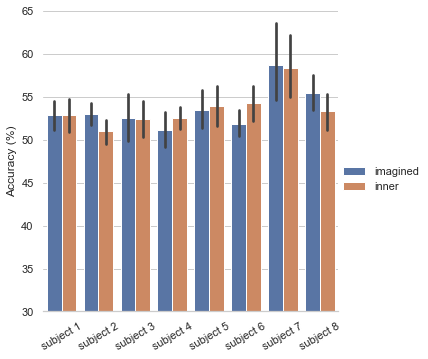

In [1505]:
sns.set_theme(style = 'whitegrid')
g = sns.catplot(
            data = df_cnnraw, 
            kind = 'bar', 
            x = 'subject', 
            y = 'accuracy', 
            hue = 'data_type'
)

g.set_xticklabels(rotation = 30)
g.set_axis_labels('', 'Accuracy (%)')
g.despine(left= True)
g.legend.set_title('')


plt.ylim(30, 65)

In [1583]:
spearmanr(lev_dists, np.mean(knn_feat_acc, axis=0)[1])[0]

0.33473096350228926

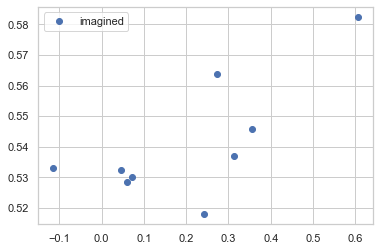

In [1574]:
# avg over the classifications
plt.plot(cos_sims, np.mean(knn_feat_acc, axis=0)[0], 'o', label = 'imagined')
# plt.plot(np.mean(cnn_raw_accs_2, axis=0)[1], 'o', label = 'inner')
plt.legend()


# Feature CNN plots

In [1511]:
df_cnnfeat = pd.DataFrame(columns=['data_type', 'subject', 'accuracy'])
data_types = ['imagined', 'inner']

for num, subject in enumerate(cnn_feat_accs):
    for d, accs in enumerate(subject):
        for acc in accs:
            df_cnnfeat.loc[len(df_cnnfeat.index)] = [data_types[d], f'subject {num+1}', acc]

df_cnnfeat.accuracy = df_cnnfeat.accuracy * 100

(30.0, 65.0)

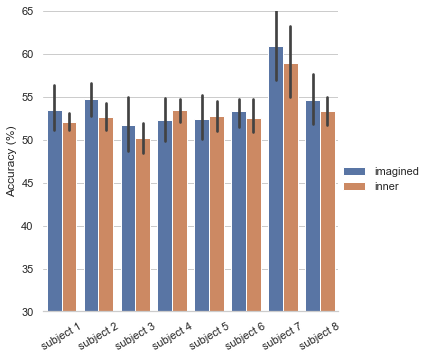

In [1530]:
sns.set_theme(style = 'whitegrid')
k = sns.catplot(
            data = df_cnnfeat, 
            kind = 'bar', 
            x = 'subject', 
            y = 'accuracy', 
            hue = 'data_type'
)

k.set_xticklabels(rotation = 30)
k.set_axis_labels('', 'Accuracy (%)')
k.despine(left= True)
k.legend.set_title('')

plt.ylim(30, 65)

In [1592]:
label_pairs

[('goose', 'moose'),
 ('moose', 'spruce'),
 ('moose', 'caterpillar'),
 ('juice', 'waterfowl'),
 ('hedgehog', 'goose'),
 ('night', 'knight'),
 ('date', 'juice'),
 ('hedgehog', 'waterfowl'),
 ('juice', 'ambassador')]

In [1590]:
np.mean(cnn_raw_accs_2, axis = 0)

array([[0.55520833, 0.55064167, 0.55763333, 0.531175  , 0.539475  ,
        0.536075  , 0.51621666, 0.518775  , 0.52213333],
       [0.54215833, 0.5382    , 0.55343333, 0.5373    , 0.53801667,
        0.52398333, 0.52501667, 0.54705833, 0.520325  ]])

In [1591]:
np.mean(cnn_raw_std_2, axis=0)

array([[0.05748784, 0.05113458, 0.04926979, 0.04858671, 0.04894233,
        0.05018366, 0.04428769, 0.05040037, 0.04697663],
       [0.0513563 , 0.05739041, 0.0515809 , 0.05084946, 0.05827755,
        0.05676057, 0.06165139, 0.0575115 , 0.05858858]])

In [1604]:
cnn_raw_wordaccs, cnn_feat_wordaccs = np.mean(cnn_raw_accs_2, axis=0), np.mean(cnn_feat_accs, axis=0)
cnn_raw_wordstds, cnn_feat_wordsstds = np.mean(cnn_raw_std_2, axis = 0),np.mean(cnn_feat_std, axis = 0)
for c, classi in enumerate(['GM', 'MS', 'MC', 'JW', 'HG', 'NK', 'DJ', 'HW', 'JA']):
    print('{}&{:.4f} $\\pm$ {:.3f}&{:.4f} $\\pm$ {:.3f}&{:.4f} $\\pm$ {:.3f}&{:.4f} $\\pm$ {:.3f} \\\\'.format(classi, cnn_raw_wordaccs[0][c], cnn_raw_wordstds[0][c], cnn_raw_wordaccs[1][c], cnn_raw_wordstds[1][c], cnn_feat_wordaccs[0][c], cnn_feat_wordsstds[0][c], cnn_feat_wordaccs[1][c], cnn_feat_wordsstds[1][c]))

GM&0.5552 $\pm$ 0.057&0.5422 $\pm$ 0.051&0.5602 $\pm$ 0.055&0.5176 $\pm$ 0.055 \\
MS&0.5506 $\pm$ 0.051&0.5382 $\pm$ 0.057&0.5481 $\pm$ 0.054&0.5293 $\pm$ 0.066 \\
MC&0.5576 $\pm$ 0.049&0.5534 $\pm$ 0.052&0.5526 $\pm$ 0.052&0.5253 $\pm$ 0.048 \\
JW&0.5312 $\pm$ 0.049&0.5373 $\pm$ 0.051&0.5381 $\pm$ 0.051&0.5213 $\pm$ 0.058 \\
HG&0.5395 $\pm$ 0.049&0.5380 $\pm$ 0.058&0.5463 $\pm$ 0.048&0.5580 $\pm$ 0.063 \\
NK&0.5361 $\pm$ 0.050&0.5240 $\pm$ 0.057&0.5476 $\pm$ 0.055&0.5267 $\pm$ 0.064 \\
DJ&0.5162 $\pm$ 0.044&0.5250 $\pm$ 0.062&0.5374 $\pm$ 0.054&0.5222 $\pm$ 0.048 \\
HW&0.5188 $\pm$ 0.050&0.5471 $\pm$ 0.058&0.5166 $\pm$ 0.059&0.5683 $\pm$ 0.063 \\
JA&0.5221 $\pm$ 0.047&0.5203 $\pm$ 0.059&0.5309 $\pm$ 0.064&0.5241 $\pm$ 0.052 \\


# SVM

In [1514]:
df_svmfeat = pd.DataFrame(columns=['data_type', 'subject', 'accuracy'])
data_types = ['imagined', 'inner']

for num, subject in enumerate(svm_feat_accs):
    for d, accs in enumerate(subject):
        for acc in accs:
            df_svmfeat.loc[len(df_svmfeat.index)] = [data_types[d], f'subject {num+1}', acc]

df_svmfeat.accuracy = df_svmfeat.accuracy * 100

(30.0, 65.0)

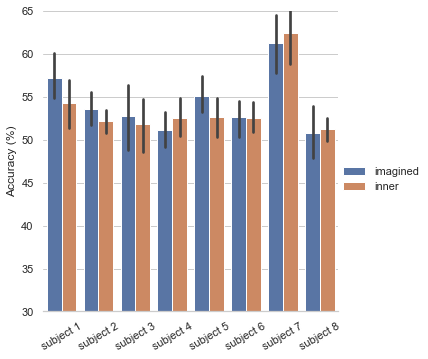

In [1515]:
sns.set_theme(style = 'whitegrid')
h = sns.catplot(
            data = df_svmfeat, 
            kind = 'bar', 
            x = 'subject', 
            y = 'accuracy', 
            hue = 'data_type'
)

h.set_xticklabels(rotation = 30)
h.set_axis_labels('', 'Accuracy (%)')
h.despine(left= True)
h.legend.set_title('')

plt.ylim(30, 65)

# SVM MFCC


In [1584]:
df_svmmfcc = pd.DataFrame(columns=['data_type', 'subject', 'accuracy'])
data_types = ['imagined', 'inner']

for num, subject in enumerate(svm_mfcc_acc):
    for d, accs in enumerate(subject):
        for acc in accs:
            df_svmmfcc.loc[len(df_svmmfcc.index)] = [data_types[d], f'subject {num+1}', acc]

df_svmmfcc.accuracy = df_svmmfcc.accuracy * 100

(30.0, 74.0)

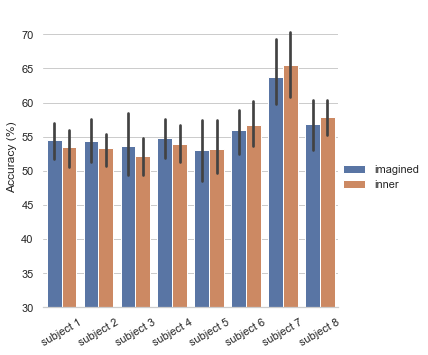

In [1587]:
sns.set_theme(style = 'whitegrid')
hj = sns.catplot(
            data = df_svmmfcc, 
            kind = 'bar', 
            x = 'subject', 
            y = 'accuracy', 
            hue = 'data_type'
)

hj.set_xticklabels(rotation = 30)
hj.set_axis_labels('', 'Accuracy (%)')
hj.despine(left= True)
hj.legend.set_title('')

plt.ylim(30, 74)

# RF


In [1516]:
df_rffeat = pd.DataFrame(columns=['data_type', 'subject', 'accuracy'])
data_types = ['imagined', 'inner']

for num, subject in enumerate(rf_feat_acc):
    for d, accs in enumerate(subject):
        for acc in accs:
            df_rffeat.loc[len(df_rffeat.index)] = [data_types[d], f'subject {num+1}', acc]

df_rffeat.accuracy = df_rffeat.accuracy * 100

(30.0, 65.0)

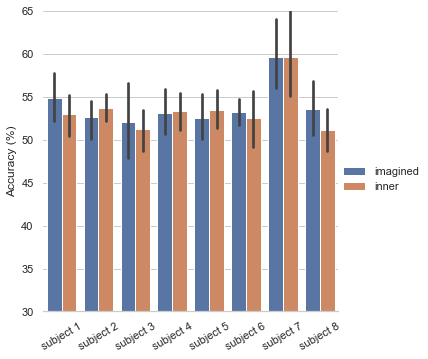

In [1519]:
from re import L


sns.set_theme(style = 'whitegrid')
gf = sns.catplot(
            data = df_rffeat, 
            kind = 'bar', 
            x = 'subject', 
            y = 'accuracy', 
            hue = 'data_type'
)

gf.set_xticklabels(rotation = 30)
gf.set_axis_labels('', 'Accuracy (%)')
gf.despine(left= True)
gf.legend.set_title('')

plt.ylim(30, 65)

# knn

In [1531]:
df_knnfeat = pd.DataFrame(columns=['data_type', 'subject', 'accuracy'])
data_types = ['imagined', 'inner']

for num, subject in enumerate(knn_feat_acc):
    for d, accs in enumerate(subject):
        for acc in accs:
            df_knnfeat.loc[len(df_knnfeat.index)] = [data_types[d], f'subject {num+1}', acc]

df_knnfeat.accuracy = df_knnfeat.accuracy * 100

(30.0, 69.0)

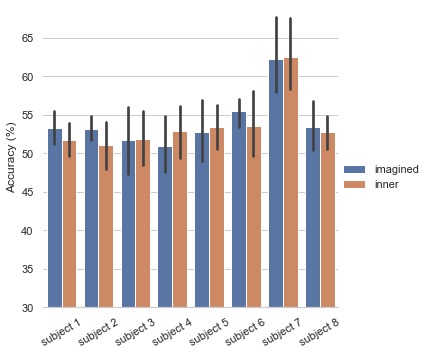

In [1535]:
sns.set_theme(style = 'whitegrid')
gk = sns.catplot(
            data = df_knnfeat, 
            kind = 'bar', 
            x = 'subject', 
            y = 'accuracy', 
            hue = 'data_type'
)

gk.set_xticklabels(rotation = 30)
gk.set_axis_labels('', 'Accuracy (%)')
gk.despine(left= True)
gk.legend.set_title('')

plt.ylim(30, 69)

In [1639]:
feat_dist = np.zeros((8, 2, 9))
for i in range(1, 9):
    print(i)
    for l, (label1, label2) in enumerate(label_pairs):
        print(l)
        data_im, lab_im = get_data('imagined', i)
        data_in, lab_in = get_data('inner', i)
        data_im, data_in = data_im.reshape(1000, 256, 14), data_in.reshape(1000, 256, 14)
        
        data_im, lab_im = binary_split(data_im, lab_im, label1, label2)
        data_in, lab_in = binary_split(data_in, lab_in, label1, label2)

        feat_im, lab_im = get_windows(data_im, lab_im, True)
        feat_in, lab_in = get_windows(data_in, lab_in, True)
        
        feat_im, feat_in = feat_im.reshape(feat_im.shape[0], feat_im.shape[1] * feat_im.shape[2]), feat_in.reshape(feat_in.shape[0], feat_in.shape[1] * feat_in.shape[2])
        feat_im, feat_in = np.nan_to_num(feat_im), np.nan_to_num(feat_in)

        feat_im, feat_in = StandardScaler().fit_transform(feat_im), StandardScaler().fit_transform(feat_in)

        avg_im_1, avg_im_0 = np.mean(feat_im[np.array(lab_im) == 1], axis = 0), np.mean(feat_im[np.array(lab_im) == 0], axis = 0)
        avg_in_1, avg_in_0 = np.mean(feat_in[np.array(lab_in) == 1], axis = 0), np.mean(feat_in[np.array(lab_in) == 0], axis = 0)
        im_dis = np.linalg.norm(avg_im_1 - avg_im_0)
        in_dis = np.linalg.norm(avg_in_1 - avg_in_0)

        feat_dist[i-1, :, l] = im_dis, in_dis

1
0
1
2
3
4
5
6
7
8
2
0
1
2
3
4
5
6
7
8
3
0
1
2
3
4
5
6
7
8
4
0
1
2
3
4
5
6
7
8
5
0
1
2
3
4
5
6
7
8
6
0
1
2
3
4
5
6
7
8
7
0
1
2
3
4
5
6
7
8
8
0
1
2
3
4
5
6
7
8


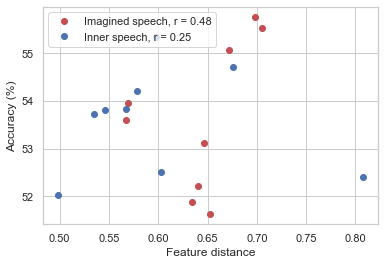

In [1656]:
# cnn_raw mean accs vs. feat dist
# imag p = 0.187
# p = 0.52
plt.plot(np.mean(feat_dist, axis=0)[0], 100 * np.mean(cnn_raw_accs_2, axis=0)[0], 'ro', label='Imagined speech, r = {:.2f}'.format(spearmanr(np.mean(feat_dist, axis=0)[0], np.mean(cnn_raw_accs_2, axis=0)[0])[0]))
plt.plot(np.mean(feat_dist, axis=0)[1], 100 * np.mean(cnn_raw_accs_2, axis=0)[1], 'bo', label = 'Inner speech, r = {:.2f}'.format(spearmanr(np.mean(feat_dist, axis=0)[1], np.mean(cnn_raw_accs_2, axis=0)[1])[0]))
plt.ylabel('Accuracy (%)')
plt.xlabel('Feature distance')
plt.legend()

In [1658]:
lev_dists

[1, 5, 11, 9, 7, 1, 4, 8, 10]

imagined p value = 0.9830
inner p value = 0.6198


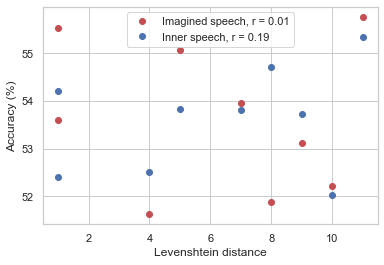

In [1662]:
plt.plot(lev_dists, 100 * np.mean(cnn_raw_accs_2, axis=0)[0], 'ro', label='Imagined speech, r = {:.2f}'.format(spearmanr(lev_dists, np.mean(cnn_raw_accs_2, axis=0)[0])[0]))
plt.plot(lev_dists, 100 * np.mean(cnn_raw_accs_2, axis=0)[1], 'bo', label = 'Inner speech, r = {:.2f}'.format(spearmanr(lev_dists, np.mean(cnn_raw_accs_2, axis=0)[1])[0]))
plt.ylabel('Accuracy (%)')
plt.xlabel('Levenshtein distance')
plt.legend()
print('imagined p value = {:.4f}'.format(spearmanr(lev_dists, np.mean(cnn_raw_accs_2, axis=0)[0])[1]))
print('inner p value = {:.4f}'.format(spearmanr(lev_dists, np.mean(cnn_raw_accs_2, axis=0)[1])[1]))

imagined p value = 0.0298
inner p value = 0.0769


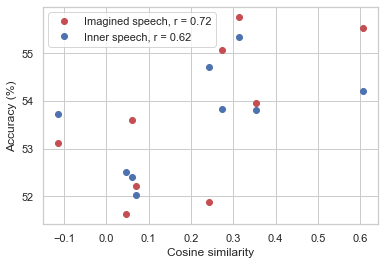

In [1664]:
plt.plot(cos_sims, 100 * np.mean(cnn_raw_accs_2, axis=0)[0], 'ro', label='Imagined speech, r = {:.2f}'.format(spearmanr(cos_sims, np.mean(cnn_raw_accs_2, axis=0)[0])[0]))
plt.plot(cos_sims, 100 * np.mean(cnn_raw_accs_2, axis=0)[1], 'bo', label = 'Inner speech, r = {:.2f}'.format(spearmanr(cos_sims, np.mean(cnn_raw_accs_2, axis=0)[1])[0]))
plt.ylabel('Accuracy (%)')
plt.xlabel('Cosine similarity')
plt.legend()
print('imagined p value = {:.4f}'.format(spearmanr(cos_sims, np.mean(cnn_raw_accs_2, axis=0)[0])[1]))
print('inner p value = {:.4f}'.format(spearmanr(cos_sims, np.mean(cnn_raw_accs_2, axis=0)[1])[1]))

imagined p value = 0.1875
inner p value = 0.5165


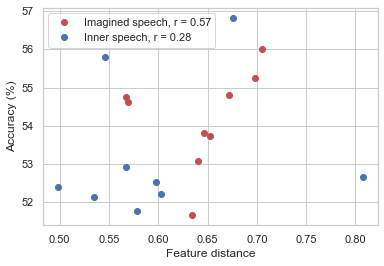

In [1665]:
# feature CNN graphs
plt.plot(np.mean(feat_dist, axis=0)[0], 100 * np.mean(cnn_feat_accs, axis=0)[0], 'ro', label='Imagined speech, r = {:.2f}'.format(spearmanr(np.mean(feat_dist, axis=0)[0], np.mean(cnn_feat_accs, axis=0)[0])[0]))
plt.plot(np.mean(feat_dist, axis=0)[1], 100 * np.mean(cnn_feat_accs, axis=0)[1], 'bo', label = 'Inner speech, r = {:.2f}'.format(spearmanr(np.mean(feat_dist, axis=0)[1], np.mean(cnn_feat_accs, axis=0)[1])[0]))
plt.ylabel('Accuracy (%)')
plt.xlabel('Feature distance')
plt.legend()
print('imagined p value = {:.4f}'.format(spearmanr(np.mean(feat_dist, axis=0)[0], np.mean(cnn_raw_accs_2, axis=0)[0])[1]))
print('inner p value = {:.4f}'.format(spearmanr(np.mean(feat_dist, axis=0)[1], np.mean(cnn_raw_accs_2, axis=0)[1])[1]))

imagined p value = 0.4175
inner p value = 0.7476


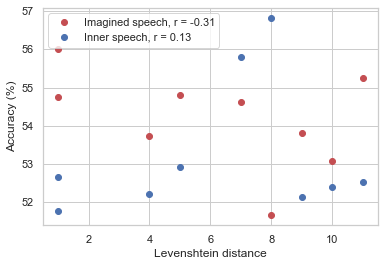

In [1666]:
plt.plot(lev_dists, 100 * np.mean(cnn_feat_accs, axis=0)[0], 'ro', label='Imagined speech, r = {:.2f}'.format(spearmanr(lev_dists, np.mean(cnn_feat_accs, axis=0)[0])[0]))
plt.plot(lev_dists, 100 * np.mean(cnn_feat_accs, axis=0)[1], 'bo', label = 'Inner speech, r = {:.2f}'.format(spearmanr(lev_dists, np.mean(cnn_feat_accs, axis=0)[1])[0]))
plt.ylabel('Accuracy (%)')
plt.xlabel('Levenshtein distance')
plt.legend()
print('imagined p value = {:.4f}'.format(spearmanr(lev_dists, np.mean(cnn_feat_accs, axis=0)[0])[1]))
print('inner p value = {:.4f}'.format(spearmanr(lev_dists, np.mean(cnn_feat_accs, axis=0)[1])[1]))

imagined p value = 0.0992
inner p value = 0.6059


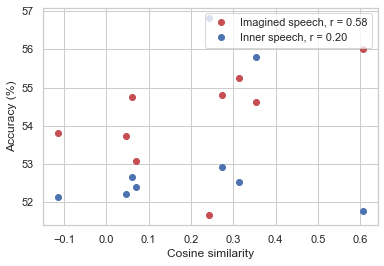

In [1668]:
plt.plot(cos_sims, 100 * np.mean(cnn_feat_accs, axis=0)[0], 'ro', label='Imagined speech, r = {:.2f}'.format(spearmanr(cos_sims, np.mean(cnn_feat_accs, axis=0)[0])[0]))
plt.plot(cos_sims, 100 * np.mean(cnn_feat_accs, axis=0)[1], 'bo', label = 'Inner speech, r = {:.2f}'.format(spearmanr(cos_sims, np.mean(cnn_feat_accs, axis=0)[1])[0]))
plt.ylabel('Accuracy (%)')
plt.xlabel('Cosine similarity')
plt.legend()
print('imagined p value = {:.4f}'.format(spearmanr(cos_sims, np.mean(cnn_feat_accs, axis=0)[0])[1]))
print('inner p value = {:.4f}'.format(spearmanr(cos_sims, np.mean(cnn_feat_accs, axis=0)[1])[1]))

In [1669]:
svm_feat_wordaccs, svm_mfcc_wordaccs = np.mean(svm_feat_accs, axis=0), np.mean(svm_mfcc_acc, axis=0)
svm_feat_wordstds, svm_mfcc_wordsstds = np.mean(svm_feat_std, axis = 0),np.mean(svm_mfcc_std, axis = 0)
for c, classi in enumerate(['GM', 'MS', 'MC', 'JW', 'HG', 'NK', 'DJ', 'HW', 'JA']):
    print('{}&{:.4f} $\\pm$ {:.3f}&{:.4f} $\\pm$ {:.3f}&{:.4f} $\\pm$ {:.3f}&{:.4f} $\\pm$ {:.3f} \\\\'.format(classi, svm_feat_wordaccs[0][c], svm_feat_wordstds[0][c], svm_feat_wordaccs[1][c], svm_feat_wordstds[1][c], svm_mfcc_wordaccs[0][c], svm_mfcc_wordsstds[0][c], svm_mfcc_wordaccs[1][c], svm_mfcc_wordsstds[1][c]))

GM&0.5669 $\pm$ 0.061&0.5403 $\pm$ 0.048&0.5916 $\pm$ 0.065&0.5415 $\pm$ 0.062 \\
MS&0.5427 $\pm$ 0.061&0.5403 $\pm$ 0.048&0.5695 $\pm$ 0.060&0.5713 $\pm$ 0.060 \\
MC&0.5499 $\pm$ 0.051&0.5320 $\pm$ 0.041&0.5839 $\pm$ 0.058&0.5789 $\pm$ 0.060 \\
JW&0.5315 $\pm$ 0.058&0.5241 $\pm$ 0.051&0.5710 $\pm$ 0.062&0.5514 $\pm$ 0.058 \\
HG&0.5543 $\pm$ 0.058&0.5468 $\pm$ 0.045&0.5575 $\pm$ 0.051&0.5684 $\pm$ 0.060 \\
NK&0.5407 $\pm$ 0.053&0.5360 $\pm$ 0.059&0.5420 $\pm$ 0.046&0.5461 $\pm$ 0.055 \\
DJ&0.5355 $\pm$ 0.036&0.5302 $\pm$ 0.049&0.5139 $\pm$ 0.052&0.5580 $\pm$ 0.053 \\
HW&0.5253 $\pm$ 0.066&0.5470 $\pm$ 0.057&0.5607 $\pm$ 0.055&0.5559 $\pm$ 0.057 \\
JA&0.5419 $\pm$ 0.061&0.5369 $\pm$ 0.052&0.5393 $\pm$ 0.042&0.5489 $\pm$ 0.049 \\


imagined p value = 0.2646
inner p value = 0.8647


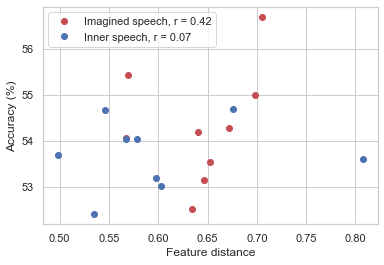

In [1670]:
# feature svm graphs
plt.plot(np.mean(feat_dist, axis=0)[0], 100 * np.mean(svm_feat_accs, axis=0)[0], 'ro', label='Imagined speech, r = {:.2f}'.format(spearmanr(np.mean(feat_dist, axis=0)[0], np.mean(svm_feat_accs, axis=0)[0])[0]))
plt.plot(np.mean(feat_dist, axis=0)[1], 100 * np.mean(svm_feat_accs, axis=0)[1], 'bo', label = 'Inner speech, r = {:.2f}'.format(spearmanr(np.mean(feat_dist, axis=0)[1], np.mean(svm_feat_accs, axis=0)[1])[0]))
plt.ylabel('Accuracy (%)')
plt.xlabel('Feature distance')
plt.legend()
print('imagined p value = {:.4f}'.format(spearmanr(np.mean(feat_dist, axis=0)[0], np.mean(svm_feat_accs, axis=0)[0])[1]))
print('inner p value = {:.4f}'.format(spearmanr(np.mean(feat_dist, axis=0)[1], np.mean(svm_feat_accs, axis=0)[1])[1]))

imagined p value = 0.6828
inner p value = 0.7313


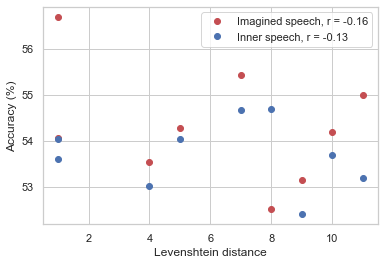

In [1671]:
plt.plot(lev_dists, 100 * np.mean(svm_feat_accs, axis=0)[0], 'ro', label='Imagined speech, r = {:.2f}'.format(spearmanr(lev_dists, np.mean(svm_feat_accs, axis=0)[0])[0]))
plt.plot(lev_dists, 100 * np.mean(svm_feat_accs, axis=0)[1], 'bo', label = 'Inner speech, r = {:.2f}'.format(spearmanr(lev_dists, np.mean(svm_feat_accs, axis=0)[1])[0]))
plt.ylabel('Accuracy (%)')
plt.xlabel('Levenshtein distance')
plt.legend()
print('imagined p value = {:.4f}'.format(spearmanr(lev_dists, np.mean(svm_feat_accs, axis=0)[0])[1]))
print('inner p value = {:.4f}'.format(spearmanr(lev_dists, np.mean(svm_feat_accs, axis=0)[1])[1]))

In [1680]:
def plot_cos(accs):
    plt.plot(cos_sims, 100 * np.mean(accs, axis=0)[0], 'ro', label='Imagined speech, r = {:.2f}'.format(spearmanr(cos_sims, np.mean(accs, axis=0)[0])[0]))
    plt.plot(cos_sims, 100 * np.mean(accs, axis=0)[1], 'bo', label = 'Inner speech, r = {:.2f}'.format(spearmanr(cos_sims, np.mean(accs, axis=0)[1])[0]))
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Cosine similarity')
    plt.legend()
    print('imagined p value = {:.4f}'.format(spearmanr(cos_sims, np.mean(accs, axis=0)[0])[1]))
    print('inner p value = {:.4f}'.format(spearmanr(cos_sims, np.mean(accs, axis=0)[1])[1]))

imagined p value = 0.0053
inner p value = 0.0671


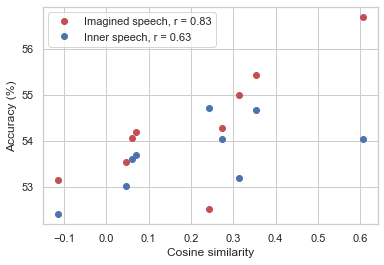

In [1681]:
plot_cos(svm_feat_accs)

In [1676]:
mfcc_dist = np.zeros((8, 2, 9))
for i in range(1, 9):
    print(i)
    for l, (label1, label2) in enumerate(label_pairs):
        print(l)
        data_im, lab_im = get_data('imagined', i)
        data_in, lab_in = get_data('inner', i)
        data_im, data_in = data_im.reshape(1000, 256, 14), data_in.reshape(1000, 256, 14)
        
        data_im, lab_im = binary_split(data_im, lab_im, label1, label2)
        data_in, lab_in = binary_split(data_in, lab_in, label1, label2)

        win, win_l, feat_im, lab_im = get_mfcc_feature_set(data_im, i, 'imagined', lab_im)
        win, win_l, feat_in, lab_in = get_mfcc_feature_set(data_in,  i, 'inner', lab_in)
        
        feat_im, feat_in = feat_im.reshape(feat_im.shape[0], feat_im.shape[1] * feat_im.shape[2]), feat_in.reshape(feat_in.shape[0], feat_in.shape[1] * feat_in.shape[2])
        feat_im, feat_in = np.nan_to_num(feat_im), np.nan_to_num(feat_in)

        feat_im, feat_in = StandardScaler().fit_transform(feat_im), StandardScaler().fit_transform(feat_in)

        avg_im_1, avg_im_0 = np.mean(feat_im[np.array(lab_im) == 1], axis = 0), np.mean(feat_im[np.array(lab_im) == 0], axis = 0)
        avg_in_1, avg_in_0 = np.mean(feat_in[np.array(lab_in) == 1], axis = 0), np.mean(feat_in[np.array(lab_in) == 0], axis = 0)
        im_dis = np.linalg.norm(avg_im_1 - avg_im_0)
        in_dis = np.linalg.norm(avg_in_1 - avg_in_0)

        mfcc_dist[i-1, :, l] = im_dis, in_dis

1
0
1
2
3
4
5
6
7
8
2
0
1
2
3
4
5
6
7
8
3
0
1
2
3
4
5
6
7
8
4
0
1
2
3
4
5
6
7
8
5
0
1
2
3
4
5
6
7
8
6
0
1
2
3
4
5
6
7
8
7
0
1
2
3
4
5
6
7
8
8
0
1
2
3
4
5
6
7
8


In [1700]:
def plot_dis(accs, dis, x_ax):
    if np.ndim(dis) == 1:
        plt.plot(dis, 100 * np.mean(accs, axis=0)[0], 'ro', label='Imagined speech, r = {:.2f}'.format(spearmanr(dis, np.mean(accs, axis=0)[0])[0]))
        plt.plot(dis, 100 * np.mean(accs, axis=0)[1], 'bo', label = 'Inner speech, r = {:.2f}'.format(spearmanr(dis, np.mean(accs, axis=0)[1])[0]))
        plt.ylabel('Accuracy (%)')
        plt.xlabel(f'{x_ax}')
        plt.legend()
        print('imagined p value = {:.4f}'.format(spearmanr(dis, np.mean(accs, axis=0)[0])[1]))
        print('inner p value = {:.4f}'.format(spearmanr(dis, np.mean(accs, axis=0)[1])[1]))
    else:
        plt.plot(np.mean(dis, axis = 0)[0], 100 * np.mean(accs, axis=0)[0], 'ro', label='Imagined speech, r = {:.2f}'.format(spearmanr(np.mean(dis, axis = 0)[0], np.mean(accs, axis=0)[0])[0]))
        plt.plot(np.mean(dis, axis = 0)[1], 100 * np.mean(accs, axis=0)[1], 'bo', label = 'Inner speech, r = {:.2f}'.format(spearmanr(np.mean(dis, axis = 0)[1], np.mean(accs, axis=0)[1])[0]))
        plt.ylabel('Accuracy (%)')
        plt.xlabel(f'{x_ax}')
        plt.legend()
        print('imagined p value = {:.4f}'.format(spearmanr(np.mean(dis, axis = 0)[0], np.mean(accs, axis=0)[0])[1]))
        print('inner p value = {:.4f}'.format(spearmanr(np.mean(dis, axis = 0)[1], np.mean(accs, axis=0)[1])[1]))

imagined p value = 0.0096
inner p value = 0.1116


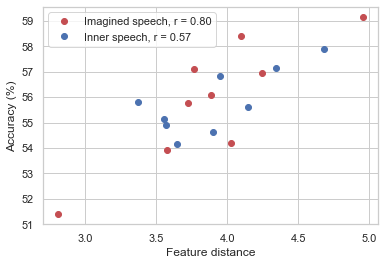

In [1701]:
plot_dis(svm_mfcc_acc, mfcc_dist, 'Feature distance')

imagined p value = 0.7640
inner p value = 0.2125


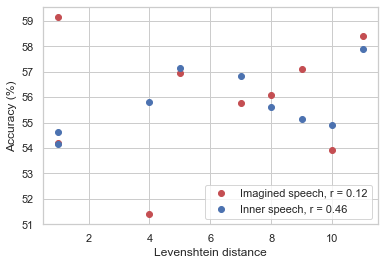

In [1702]:
plot_dis(svm_mfcc_acc, np.array(lev_dists), 'Levenshtein distance')

imagined p value = 0.0499
inner p value = 1.0000


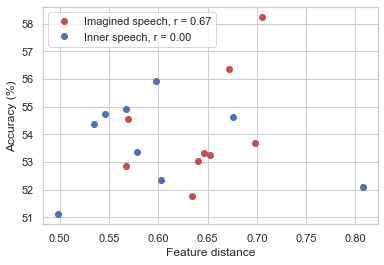

imagined p value = 0.6511
inner p value = 0.3786


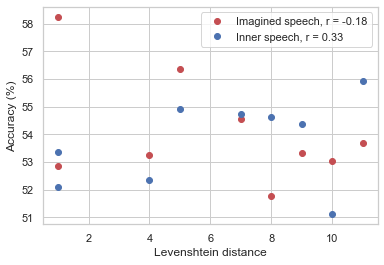

imagined p value = 0.0671
inner p value = 0.1875


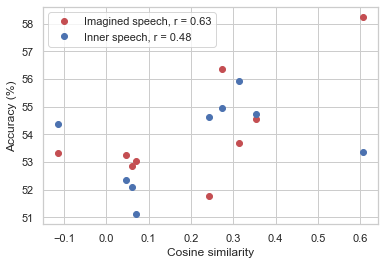

In [1706]:
dists = [feat_dist, lev_dists, cos_sims]
xlabs = ['Feature distance', 'Levenshtein distance', 'Cosine similarity']
for i, dist in enumerate(dists):
    plot_dis(knn_feat_acc, dist, f'{xlabs[i]}')
    plt.show()

In [1718]:
svm_longwords_acc = np.zeros((8, 2, 4))
svm_longwords_std = np.zeros((8, 2, 4))
for i in range(1,9):
    for d, data_type in enumerate(['imagined', 'inner']):
        data, labels = get_data(data_type, i)
        for l, (label1, label2) in enumerate([('ambassador', 'watermelon'), ('caterpillar', 'environment'), ('date', 'knight'), ('queen', 'juice')]):
            m, s = test_svm_mfcc(data, labels, i, data_type, label1, label2)
            svm_longwords_acc[i - 1][d][l] += m
            svm_longwords_std[i - 1][d][l] += s

Subject 8, imagined
SVM-rbf MFCCs Binary classification between ambassador and watermelon for subject 8, imagined
10 fold Cross-validated accuracy: 0.48 +- 0.06521420521622166

Subject 8, imagined
SVM-rbf MFCCs Binary classification between caterpillar and environment for subject 8, imagined
10 fold Cross-validated accuracy: 0.5163636363636364 +- 0.07039440248220341

Subject 8, imagined
SVM-rbf MFCCs Binary classification between date and knight for subject 8, imagined
10 fold Cross-validated accuracy: 0.5636363636363635 +- 0.06741998624632418

Subject 8, imagined
SVM-rbf MFCCs Binary classification between queen and juice for subject 8, imagined
10 fold Cross-validated accuracy: 0.5972727272727273 +- 0.05282123289575985

Subject 8, inner
SVM-rbf MFCCs Binary classification between ambassador and watermelon for subject 8, inner
10 fold Cross-validated accuracy: 0.5281818181818181 +- 0.04898979485566354

Subject 8, inner
SVM-rbf MFCCs Binary classification between caterpillar and enviro

In [1720]:
long_short = [('ambassador', 'watermelon'), ('caterpillar', 'environment'), ('date', 'knight'), ('queen', 'juice')]

In [1724]:
cos_similarity[long_short[0][0] + ' '+ long_short[0][1]]

0.061769374

In [1725]:
for word1, word2 in long_short[1:]:
    key = word1 + ' ' + word2
    print('{}&{}&{}&{}&{:.4f} \\\\ '.format(word1, word2, str.upper(word1[0]) + str.upper(word2[0]), lev(word1, word2), cos_similarity[key]))

caterpillar&environment&CE&10&0.0638 \\ 
date&knight&DK&6&-0.0031 \\ 
queen&juice&QJ&4&0.0372 \\ 


In [1727]:
svm_longwords_acc.shape

(8, 2, 4)

In [1728]:
np.mean(svm_longwords_acc, axis = 0)

array([[0.5525    , 0.55318182, 0.53761364, 0.56056818],
       [0.54625   , 0.54636364, 0.53818182, 0.55693182]])

In [1735]:
np.mean(svm_longwords_acc, axis = 0)

array([[0.5525    , 0.55318182, 0.53761364, 0.56056818],
       [0.54625   , 0.54636364, 0.53818182, 0.55693182]])

In [1737]:
svm_longwords_acc

array([[[0.66454545, 0.60545455, 0.43818182, 0.53818182],
        [0.64363636, 0.57818182, 0.63818182, 0.48363636]],

       [[0.47727273, 0.6       , 0.48181818, 0.53818182],
        [0.52636364, 0.54454545, 0.48636364, 0.49454545]],

       [[0.54090909, 0.55727273, 0.61545455, 0.47363636],
        [0.48545455, 0.45090909, 0.51272727, 0.50636364]],

       [[0.50909091, 0.41909091, 0.51909091, 0.59363636],
        [0.53545455, 0.52727273, 0.47181818, 0.61454545]],

       [[0.61      , 0.58181818, 0.57909091, 0.57363636],
        [0.51545455, 0.49636364, 0.56909091, 0.53818182]],

       [[0.60909091, 0.54909091, 0.56090909, 0.50636364],
        [0.52727273, 0.58272727, 0.54090909, 0.58909091]],

       [[0.52909091, 0.59636364, 0.54272727, 0.66363636],
        [0.60818182, 0.56      , 0.55727273, 0.60909091]],

       [[0.48      , 0.51636364, 0.56363636, 0.59727273],
        [0.52818182, 0.63090909, 0.52909091, 0.62      ]]])

In [1753]:
svm_mfcc_acc[0]

array([[0.61636364, 0.53909091, 0.55454545, 0.53454545, 0.54090909,
        0.52727273, 0.47363636, 0.51727273, 0.60272727],
       [0.57454545, 0.49090909, 0.56454545, 0.51909091, 0.52090909,
        0.57272727, 0.45727273, 0.51545455, 0.59909091]])

In [1758]:
# longs = pd.DataFrame(columns=['accuracy', 'data_type', 'long_short'])

longs = pd.DataFrame(columns=['data_type', 'subject', 'accuracy', 'long_short'])
data_types = ['imagined', 'inner']
l = ['long words', 'long words', 'short words', 'short words']
g = ['short words', 'short words', 'short / long', 'short / long', 'short words', 
        'short words', 'short words', 'long words', 'short / long']
for num, subject in enumerate(svm_longwords_acc):
    for d, accs in enumerate(subject):
        for a, acc in enumerate(accs):
            longs.loc[len(longs.index)] = [data_types[d], f'subject {num+1}', acc, l[a]]
        for b, acc in enumerate(svm_mfcc_acc[num][d]):
            longs.loc[len(longs.index)] = [data_types[d], f'subject {num+1}', acc, g[b]]

longs.accuracy = longs.accuracy * 100

In [1759]:
longs

,data_type,subject,accuracy,long_short
0,imagined,subject 1,66.454545,long words
1,imagined,subject 1,60.545455,long words
2,imagined,subject 1,43.818182,short words
3,imagined,subject 1,53.818182,short words
4,imagined,subject 1,61.636364,short words
...,...,...,...,...
203,inner,subject 8,65.727273,short words
204,inner,subject 8,54.181818,short words
205,inner,subject 8,57.545455,short words
206,inner,subject 8,53.181818,long words


(30.0, 69.0)

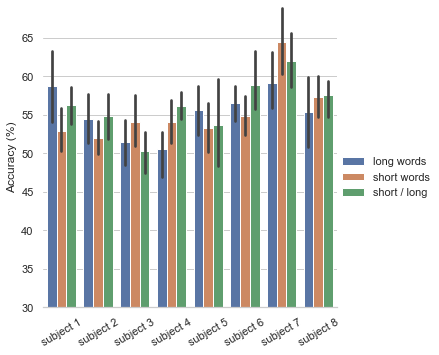

In [1760]:
sns.set_theme(style = 'whitegrid')
gk = sns.catplot(
            data = longs, 
            kind = 'bar', 
            x = 'subject', 
            y = 'accuracy', 
            hue = 'long_short'
)

gk.set_xticklabels(rotation = 30)
gk.set_axis_labels('', 'Accuracy (%)')
gk.despine(left= True)
gk.legend.set_title('')

plt.ylim(30, 69)

In [1786]:
# make a table automatically given an accuracy and standard deviation pairing. 
acc = cnn_raw_accs_2[0]
std = cnn_raw_std_2[0]

In [1787]:
prompt_pairings = [w1[0].upper() + w2[0].upper() for (w1, w2) in label_pairs]

In [1788]:
prompt_pairings

['GM', 'MS', 'MC', 'JW', 'HG', 'NK', 'DJ', 'HW', 'JA']

In [1857]:
'raw input Cnn'[0:3]

'raw'

In [1877]:
accuracies = [cnn_raw_accs_2, cnn_feat_accs, svm_feat_accs, svm_mfcc_acc, rf_feat_acc, knn_feat_acc]
standard_devs = [cnn_raw_std_2, cnn_feat_std, svm_feat_std, svm_mfcc_std, rf_feat_std, knn_feat_std]
model_labels = ['raw input CNN', 'feature input CNN', 'feature inpute SVM', 'MFCC-SVM', 'RF', 'kNN']
labs = ['raw_input_cnn', 'feat_input_cnn', 'feat_input_svm', 'mfcc_svm', 'rf_feat', 'knn']
section_headers = ['Raw CNN', 'Feature CNN', 'Feature SVM', 'MFCC-SVM', 'RF', 'kNN']

for i, (accuracy, standard) in enumerate(zip(accuracies, standard_devs)):
    print(f'\\subsection\u007b{section_headers[i]}\u007d')
    for subject_num in range(8):
        acc = accuracy[subject_num]
        std = standard[subject_num]    
        print('\\begin{table}[h!]')
        print('    \\centering')
        print(f'    \\caption\u007bAverage accuracies across all prompts using the {model_labels[i]} model for subject {subject_num+1}\u007d')
        print('    \\begin{tabular}{ccc}')
        print('         \\toprule')
        print('         Prompt pairing & Imagined & Inner \\\\')
        print('         \\midrule')
        for j, row in enumerate(acc.T):
            print('         {} & {:.4f} $\\pm$ {:.4f} & {:.4f} $\\pm$ {:.4f} \\\\'.format(prompt_pairings[j], row[0], std.T[j][0], row[1], std.T[j][0]))

        print('         \\bottomrule \\\\')
        print('    \\end{tabular}')
        print(f'    \\label\u007btab:{labs[i]}{subject_num+1}\u007d')
        print('\\end{table}')
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

\subsection{Raw CNN}
\begin{table}[h!]
    \centering
    \caption{Average accuracies across all prompts using the raw input CNN model for subject 1}
    \begin{tabular}{ccc}
         \toprule
         Prompt pairing & Imagined & Inner \\
         \midrule
         GM & 0.5597 $\pm$ 0.0389 & 0.5633 $\pm$ 0.0389 \\
         MS & 0.5368 $\pm$ 0.0274 & 0.5121 $\pm$ 0.0274 \\
         MC & 0.5544 $\pm$ 0.0450 & 0.5731 $\pm$ 0.0450 \\
         JW & 0.5217 $\pm$ 0.0487 & 0.5387 $\pm$ 0.0487 \\
         HG & 0.5045 $\pm$ 0.0351 & 0.5035 $\pm$ 0.0351 \\
         NK & 0.5223 $\pm$ 0.0430 & 0.5298 $\pm$ 0.0430 \\
         DJ & 0.4843 $\pm$ 0.0274 & 0.4804 $\pm$ 0.0274 \\
         HW & 0.5032 $\pm$ 0.0255 & 0.5071 $\pm$ 0.0255 \\
         JA & 0.5709 $\pm$ 0.0382 & 0.5535 $\pm$ 0.0382 \\
         \bottomrule \\
    \end{tabular}
    \label{tab:raw_input_cnn1}
\end{table}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\begin{table}[h!]
    \centering
    \caption{Average accuracies across all prompts using 